In [110]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import beamsim

# Set seaborn style for beautiful plots
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 11

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
def plot1(items, ax: plt.Axes = None, topology_name=""):
    _, _, validator_count, snark2_threshold = beamsim.filter_report(items, "info")[0]
    snark1_sent = beamsim.filter_report(items, "snark1_sent")
    snark1_received = beamsim.get_snark1_received(items)
    snark2_sent = beamsim.filter_report(items, "snark2_sent")

    show = ax is None
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 6))

    # Use seaborn color palette
    colors = sns.color_palette("husl", 3)

    # Plot with enhanced styling
    ax.step(
        [0, *beamsim.time_axis(snark1_sent)],
        [0, *np.cumsum([x[2] for x in snark1_sent])],
        where="post",
        color=colors[0],
        linewidth=2.5,
        label="SNARK1 Sent (Cumulative)",
        alpha=0.8,
    )
    ax.step(
        [0, *beamsim.time_axis(snark1_received)],
        [0, *[x[2] for x in snark1_received]],
        where="post",
        color=colors[1],
        linewidth=2.5,
        label="SNARK1 Received",
        alpha=0.8,
    )

    # Enhanced reference lines
    ax.axhline(
        validator_count,
        linestyle="--",
        color=colors[0],
        alpha=0.7,
        linewidth=2,
        label=f"Validator Count ({validator_count})",
    )
    ax.axhline(
        snark2_threshold,
        linestyle="--",
        color=colors[1],
        alpha=0.7,
        linewidth=2,
        label=f"SNARK2 Threshold ({snark2_threshold})",
    )

    if snark2_sent:
        snark2_time = snark2_sent[0][0]
        ax.axvline(
            snark2_time,
            linestyle=":",
            color=colors[2],
            alpha=0.8,
            linewidth=2,
            label=f"SNARK2 Sent Time ({snark2_time})",
        )

    # Enhanced styling
    ax.set_xlabel("Time", fontweight="bold")
    ax.set_ylabel("Count", fontweight="bold")
    if topology_name:
        ax.set_title(
            f"SNARK Distribution - {topology_name.title()} Topology",
            fontweight="bold",
            fontsize=14,
        )

    ax.legend(frameon=True, fancybox=True, shadow=True)
    ax.grid(True, alpha=0.3)

    if show:
        plt.tight_layout()
        plt.show()


def plot1_topologies(**run_kwargs):
    topologies = list(beamsim.topology_name.keys())
    # Create enhanced subplots with better spacing
    fig, axes = plt.subplots(nrows=len(topologies), figsize=(12, 15), sharex=True)
    fig.suptitle(
        "SNARK Distribution Across Different Network Topologies",
        fontsize=16,
        fontweight="bold",
        y=0.95,
    )

    for topology, ax in zip(topologies, axes):
        plot1(
            beamsim.run(**run_kwargs, t=topology), ax, beamsim.topology_name[topology]
        )

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

In [112]:
def plot2(items, ax: plt.Axes = None, topology_name=""):
    metrics = beamsim.Metrics(items)

    show = ax is None
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 6))

    # Create a more structured data approach
    time_points = range(metrics.t)
    colors = sns.color_palette("Set2", 3)

    for y, label, color in zip(metrics.bytes_sent_role_avg, beamsim.role_name, colors):
        ax.plot(
            time_points,
            y,
            label=label,
            linewidth=3,
            color=color,
            marker="o",
            markersize=4,
            alpha=0.8,
        )

    ax.set_xlabel("Time Step", fontweight="bold")
    ax.set_ylabel("Average Bytes Sent", fontweight="bold")
    if topology_name:
        ax.set_title(
            f"Network Traffic by Role - {topology_name} Topology",
            fontweight="bold",
            fontsize=14,
        )

    ax.legend(frameon=True, fancybox=True, shadow=True, loc="upper left")
    ax.grid(True, alpha=0.3)

    # Add some styling enhancements
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    if show:
        plt.tight_layout()
        plt.show()


def plot2_topologies(topologies=beamsim.topologies, **run_kwargs):
    # Create a comprehensive comparison plot
    fig, axes = plt.subplots(
        nrows=len(topologies), figsize=(14, 12), sharex=True, sharey=True
    )
    fig.suptitle(
        "Network Traffic Analysis Across Different Topologies",
        fontsize=16,
        fontweight="bold",
        y=0.95,
    )

    # Run simulations and plot
    for topology, ax in zip(topologies, axes):
        items = beamsim.run(**run_kwargs, t=topology)
        plot2(items, ax, beamsim.topology_name[topology])

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

In [113]:
def plot3_topologies(topologies=beamsim.topologies, **run_kwargs):
    # Additional: Create separate plots for sent and received bytes
    fig, axes = plt.subplots(2, 1, figsize=(12, 16))

    # Collect data for all topologies
    all_data_sent = []
    all_data_received = []
    for topology in topologies:
        items = beamsim.run(**run_kwargs, t=topology)
        metrics = beamsim.Metrics(items)

        # Calculate total bytes sent and received for each role
        for bytes_sent, bytes_received, role in zip(
            metrics.bytes_sent_role, metrics.bytes_received_role, beamsim.role_name
        ):
            all_data_sent.append(
                {
                    "Topology": beamsim.topology_name[topology],
                    "Role": role,
                    "Total Bytes (MB)": bytes_sent[-1] / (1024 * 1024),
                }
            )
            all_data_received.append(
                {
                    "Topology": beamsim.topology_name[topology],
                    "Role": role,
                    "Total Bytes (MB)": bytes_received[-1] / (1024 * 1024),
                }
            )

    # Create DataFrames
    df_sent = pd.DataFrame(all_data_sent)
    df_received = pd.DataFrame(all_data_received)

    # Plot sent bytes
    sns.barplot(data=df_sent, x="Topology", y="Total Bytes (MB)", hue="Role", ax=axes[0])
    axes[0].set_title(
        "Total Sent Network Traffic by Topology and Role", fontweight="bold", fontsize=14
    )
    axes[0].set_ylabel("Total Bytes Sent (MB)", fontweight="bold")
    axes[0].set_xlabel("Network Topology", fontweight="bold")
    axes[0].legend(title="Node Role", frameon=True, fancybox=True, shadow=True)

    # Plot received bytes
    sns.barplot(data=df_received, x="Topology", y="Total Bytes (MB)", hue="Role", ax=axes[1])
    axes[1].set_title(
        "Total Received Network Traffic by Topology and Role", fontweight="bold", fontsize=14
    )
    axes[1].set_ylabel("Total Bytes Received (MB)", fontweight="bold")
    axes[1].set_xlabel("Network Topology", fontweight="bold")
    axes[1].legend(title="Node Role", frameon=True, fancybox=True, shadow=True)

    plt.tight_layout()
    plt.show()

In [114]:
def plot4_topologies(topologies=beamsim.topologies, **run_kwargs):
    import warnings

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        all_data = []
        for topology in topologies:
            items = beamsim.run(**run_kwargs, t=topology)
            metrics = beamsim.Metrics(items)
            for bytes_sent, bytes_recv, role in zip(
                metrics.bytes_sent_role_avg, metrics.bytes_received_role_avg, beamsim.role_name
            ):
                window = 1000  # 1000ms window
                if len(bytes_sent) > window and len(bytes_recv) > window:
                    # Outgoing (sent)
                    peak_sent = max(
                        bytes_sent[i + window] - bytes_sent[i]
                        for i in range(len(bytes_sent) - window)
                    )
                    peak_sent_mbps = (peak_sent * 8) / (1000 * 1000)  # bytes -> bits -> Mbps
                    all_data.append(
                        {
                            "Topology": beamsim.topology_name[topology],
                            "Role": role,
                            "Peak": peak_sent_mbps,
                            "Direction": "Outgoing",
                        }
                    )
                    # Incoming (received)
                    peak_recv = max(
                        bytes_recv[i + window] - bytes_recv[i]
                        for i in range(len(bytes_recv) - window)
                    )
                    peak_recv_mbps = (peak_recv * 8) / (1000 * 1000)
                    all_data.append(
                        {
                            "Topology": beamsim.topology_name[topology],
                            "Role": role,
                            "Peak": peak_recv_mbps,
                            "Direction": "Incoming",
                        }
                    )
        df = pd.DataFrame(all_data)
        g = sns.catplot(
            data=df,
            x="Topology",
            y="Peak",
            hue="Role",
            col="Direction",
            kind="bar",
            ci=None,
            height=7,
            aspect=1.1,
            dodge=True,
            legend_out=False
        )
        g.set_titles("{col_name} Traffic")
        g.set_axis_labels("Network Topology", "Peak Traffic (Mbps)")
        g.fig.suptitle(
            "Peak Network Traffic by Topology, Role, and Direction", fontweight="bold", fontsize=15, y=1.05
        )
        for ax in g.axes.flat:
            ax.set_ylabel("Peak Traffic (Mbps)", fontweight="bold")
            ax.set_xlabel("Network Topology", fontweight="bold")
            ax.grid(True, axis="y", alpha=0.3)
        g.add_legend(title="Role", frameon=True, fancybox=True, shadow=True)  # Ensure legend is displayed
        plt.tight_layout()
        plt.show()

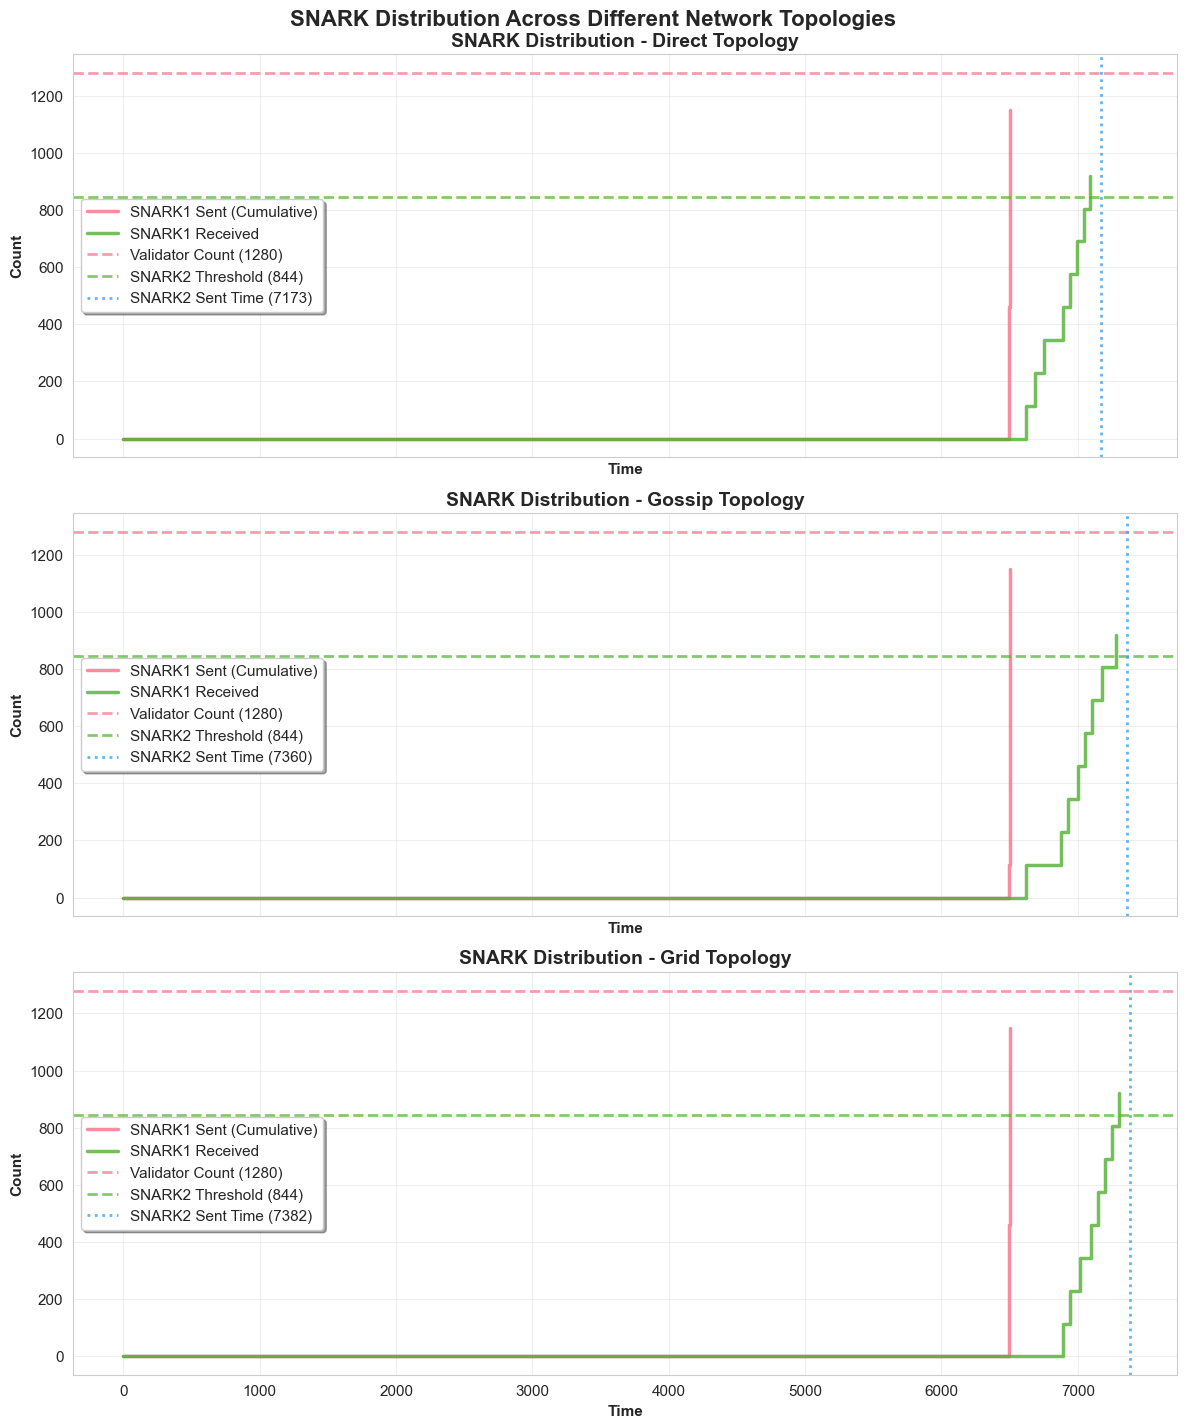

In [115]:
run_kwargs = dict(b="ns3-direct", g=10, gv=128, mpi=10)

plot1_topologies(**run_kwargs)
# plot2_topologies(**run_kwargs)
# plot3_topologies(**run_kwargs)
# plot4_topologies(**run_kwargs)